In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from xgboost import XGBClassifier
import pickle
import streamlit as st
import joblib 

In [2]:
df=pd.read_csv('data_C.csv',delimiter=',')
df

,Unnamed: 0,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
0,0,157138,15638646,Chinweike,628.0,Spain,Female,50.0,4,160133.08,1,1,1,653.53,0
1,1,116144,15695825,Onwumelu,710.0,Spain,Male,34.0,8,0.00,2,1,1,72993.73,0
2,2,145603,15592765,Marks,663.0,France,Female,23.0,8,125470.81,1,1,1,174536.17,0
3,3,79929,15807525,Onyemachukwu,644.0,Spain,Male,45.0,8,0.00,2,0,1,28690.90,0
4,4,52554,15611551,Hill,627.0,Spain,Male,23.0,5,0.00,2,1,0,134483.07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41253,41253,55217,15641043,Onyemere,641.0,Germany,Male,38.0,2,138166.30,2,0,1,69227.66,0
41254,41254,110969,15674541,Robinson,575.0,France,Male,52.0,8,0.00,2,0,1,111342.66,0
41255,41255,132494,15700601,Kao,571.0,France,Male,34.0,1,119452.03,2,1,1,173511.72,0
41256,41256,31177,15806926,Nkemjika,624.0,France,Male,38.0,4,0.00,1,0,0,40320.30,0


# 1. Preprocessing and Modelling

## Drop unecessary categorical column 

Drop column 'Unamed:0','id','CustomerId','Surname' karena tidak memengaruhi hasil prediksi churn/ not churn

In [3]:
df = df.drop(['Unnamed: 0','id','CustomerId','Surname'], axis = 1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
0,628.0,Spain,Female,50.0,4,160133.08,1,1,1,653.53,0
1,710.0,Spain,Male,34.0,8,0.00,2,1,1,72993.73,0
2,663.0,France,Female,23.0,8,125470.81,1,1,1,174536.17,0
3,644.0,Spain,Male,45.0,8,0.00,2,0,1,28690.90,0
4,627.0,Spain,Male,23.0,5,0.00,2,1,0,134483.07,0


## Handling missing value

In [4]:
df.isna().sum()

CreditScore        12
Geography           0
Gender              0
Age                 0
Tenure              0
Balance             0
NumOfProducts       0
HasCrCard           0
IsActiveMember      0
EstimatedSalary     0
churn               0
dtype: int64

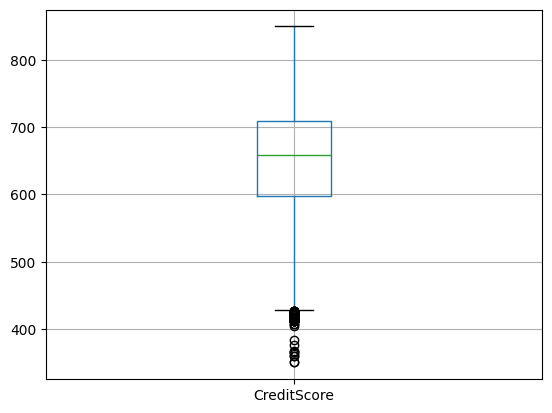

In [5]:
# Check Outliers
boxplot = df.boxplot(column=['CreditScore'])
plt.show()

dapat diketahui kalau kolom CreditScore memiliki 12 missing value yang akan kita isi dengan mean valuenya

In [6]:
# Calculate mean value for 'CreditScore'
cs_mean = round(np.mean(df['CreditScore']), 0)
print('CreditScore Mean:', cs_mean)

CreditScore Mean: 656.0


In [7]:
# Impute missing value with mean value
df['CreditScore'].fillna(cs_mean, inplace = True)
df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
churn              0
dtype: int64

In [8]:
for i in df.columns:
    print(df[i].value_counts())
    print()

CreditScore
850.0    594
678.0    561
684.0    459
667.0    408
683.0    395
        ... 
363.0      1
376.0      1
423.0      1
405.0      1
427.0      1
Name: count, Length: 444, dtype: int64

Geography
France     23469
Spain       9057
Germany     8732
Name: count, dtype: int64

Gender
Male      23219
Female    18039
Name: count, dtype: int64

Age
37.00    2351
38.00    2317
35.00    2241
34.00    2148
36.00    2135
         ... 
83.00       1
84.00       1
85.00       1
36.44       1
81.00       1
Name: count, Length: 71, dtype: int64

Tenure
7     4516
2     4469
8     4424
5     4297
4     4253
9     4240
1     4177
3     4114
6     3960
10    1491
0     1317
Name: count, dtype: int64

Balance
0.00         22471
124577.33       26
129855.32       20
122314.50       18
127864.40       16
             ...  
136612.85        1
144954.66        1
150635.20        1
157842.92        1
95252.98         1
Name: count, Length: 11410, dtype: int64

NumOfProducts
2    21080
1    19305
3   

## Encoding

Encode categorical data to numerical data

In [9]:
df['Geography'].value_counts()

Geography
France     23469
Spain       9057
Germany     8732
Name: count, dtype: int64

In [10]:
df['Gender'].value_counts()

Gender
Male      23219
Female    18039
Name: count, dtype: int64

In [11]:
# Label encoding
df_encode = {'Gender': {'Male':1,'Female':0}}
df = df.replace(df_encode)

df_encode = {'Geography': {'Germany':2,'Spain':1,'France':0}}
df = df.replace(df_encode)

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
0,628.0,1,0,50.0,4,160133.08,1,1,1,653.53,0
1,710.0,1,1,34.0,8,0.00,2,1,1,72993.73,0
2,663.0,0,0,23.0,8,125470.81,1,1,1,174536.17,0
3,644.0,1,1,45.0,8,0.00,2,0,1,28690.90,0
4,627.0,1,1,23.0,5,0.00,2,1,0,134483.07,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41258 entries, 0 to 41257
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      41258 non-null  float64
 1   Geography        41258 non-null  int64  
 2   Gender           41258 non-null  int64  
 3   Age              41258 non-null  float64
 4   Tenure           41258 non-null  int64  
 5   Balance          41258 non-null  float64
 6   NumOfProducts    41258 non-null  int64  
 7   HasCrCard        41258 non-null  int64  
 8   IsActiveMember   41258 non-null  int64  
 9   EstimatedSalary  41258 non-null  float64
 10  churn            41258 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.5 MB


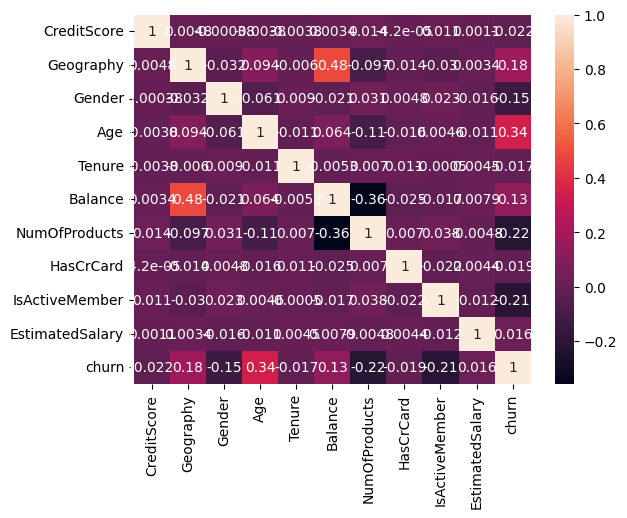

In [13]:
sns.heatmap(df.corr(), annot = True)
plt.show()

Tidak ada variabel dengan korelasi tinggi yang harus didrop


## Split data into training and testing

In [14]:
input  = df.drop('churn', axis=1)
output = df['churn']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.2, random_state= 42)
x_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
15731,725.0,1,0,31.0,2,0.00,2,0,0,71830.10
6996,688.0,1,1,36.0,4,0.00,1,1,0,129870.93
30824,748.0,0,0,23.0,7,118028.35,1,0,1,41626.78
40019,701.0,0,0,45.0,5,0.00,2,1,1,158948.63
21501,590.0,0,0,23.0,5,113923.81,3,1,0,196789.90


- Random Forest

In [16]:
RF_class = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4, random_state=42)
RF_class.fit(x_train,y_train)

RandomForestClassifier(max_depth=4, random_state=42)

In [17]:
y_pred_RF = RF_class.predict(x_test)
print('\nClassification Report\n')
print(classification_report(y_test, y_pred_RF, target_names=['0','1']))


Classification Report

              precision    recall  f1-score   support

           0       0.84      0.98      0.91      6431
           1       0.81      0.36      0.50      1821

    accuracy                           0.84      8252
   macro avg       0.83      0.67      0.70      8252
weighted avg       0.84      0.84      0.82      8252



- XGBoost

In [18]:
xgb_class = xgb.XGBClassifier(objective='multi:softmax', num_class=2, random_state=42)
xgb_class.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=2,
              num_parallel_tree=None, ...)

In [19]:
y_pred_xgb = xgb_class.predict(x_test)
print('\nClassification Report\n')
print(classification_report(y_test, y_pred_xgb, target_names=['0','1']))


Classification Report

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6431
           1       0.73      0.58      0.65      1821

    accuracy                           0.86      8252
   macro avg       0.81      0.76      0.78      8252
weighted avg       0.85      0.86      0.85      8252



Dari kedua model tersebut best modelnya adalah XGBoost yang memiliki accuracy 0.86 di saat Random Forest memiliki accuracy 0.84.

Lalu best model tersebut kita bikin ke pkl filenya 

In [20]:
filename = 'xgb_class.pkl'
pickle.dump(xgb_class, open(filename, 'wb'))

# 2. OOP Code

code in xgboop.py

In [21]:
class Data_C_Model:
    def __init__(self, data_file):
        self.df = pd.read_csv(data_file, delimiter=',')
        self.x_train, self.x_test, self.y_train, self.y_test = None, None, None, None

    def preprocess_data(self):
        self.df = self.df.drop(['Unnamed: 0','id','CustomerId','Surname'], axis = 1)
        
        # Replace missing values
        self._replace_missing_values(self.df)
        self._replace_missing_values(self.df)

        # Encode categorical features
        self._encode_categorical_features(self.df)
        self._encode_categorical_features(self.df)
        
        input_df = self.df.drop('churn', axis=1)
        output_df = self.df['churn']
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(input_df, output_df, test_size=0.2, random_state=42)

    def _replace_missing_values(self, data):
        data['CreditScore'].fillna(round(data['CreditScore'].mean(),0), inplace=True)

    def _encode_categorical_features(self, data):
        encode_mapping = {"Gender": {"Male": 1, "Female": 0}, 'Geography': {'Germany':3,'Spain':2,'France':1}}
        data.replace(encode_mapping, inplace=True)

    def train_model(self):
        xgb_class = xgb.XGBClassifier()
        xgb_class.fit(self.x_train, self.y_train)
        return xgb_class

    def evaluate_model(self, model):
        y_predict = model.predict(self.x_test)
        print('\nClassification Report\n')
        print(classification_report(self.y_test, y_predict, target_names=['0', '1']))

def main():
    model = Data_C_Model('data_C.csv')
    model.preprocess_data()
    trained_model = model.train_model()
    model.evaluate_model(trained_model)

if __name__ == "__main__":
    main()



Classification Report

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6431
           1       0.74      0.58      0.65      1821

    accuracy                           0.86      8252
   macro avg       0.81      0.76      0.78      8252
weighted avg       0.85      0.86      0.86      8252



# 3. Streamlit prediction

code in streamlit.py

In [22]:
df.describe()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn
count,41258.000000,41258.000000,41258.000000,41258.000000,41258.000000,41258.000000,41258.000000,41258.000000,41258.000000,41258.000000,41258.000000
mean,655.802947,0.642809,0.562776,38.165611,5.036308,55308.965471,1.556038,0.754011,0.496776,112507.486040,0.214455
std,79.724701,0.808028,0.496050,8.947665,2.817831,62795.530950,0.548029,0.430677,0.499996,50048.666663,0.410449
min,350.000000,0.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,0.000000,0.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74564.410000,0.000000
50%,659.000000,0.000000,1.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117616.290000,0.000000
75%,710.000000,1.000000,1.000000,42.750000,7.000000,119785.395000,2.000000,1.000000,1.000000,154700.647500,0.000000
max,850.000000,2.000000,1.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.000000
